In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from iit_tpm import make_tpm, tpm_series
from grn_tpm import iit_tpm_cal

def decimal_to_binary(decimal, min_length=1):
    if min_length == 0:
        return ''
    if decimal == 0:
        return "0" if min_length == 1 else "0".zfill(min_length)
    binary = ""
    while decimal > 0:
        binary = str(decimal % 2) + binary
        decimal = decimal // 2
    # 使用 zfill 确保二进制字符串至少有 min_length 长度
    return binary.zfill(min_length)

def serie_plot(bnet, w, k, steps, seeds=1, name=''):
    tpm, tpm_v = make_tpm(bnet, w=w, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
    colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
    strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
    for init_state in strs:
        fig, ax = plt.subplots(figsize=(10,4),dpi=150)
        for indx,en in enumerate(["00", "01", "10", "11"]):
            en_state = en
            for seed in range(seeds):
                serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

                # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
                ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

        # 设置轴标签
        ax.set_xlabel('Time')
        ax.set_ylabel('System state')

        # 设置y轴的标签
        ax.set_yticks(range(8))
        ax.set_yticklabels(strs)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
        plt.title(name + '_init=' + init_state + '_syn=' + str(syn))
        # 显示图形
        plt.show()
        
    return un_sys, un_en, syn

# 不同环境状态下系统演化序列比较

In [2]:
# w1 = {
#     'w1': 0.9,
#     'w2': 0.9,
#     'w3': 0.9,
#     'w4': 0.8,
#     'w5': -0.01,
#     'w6': -0.01
# }

# w2 = {
#     'w1': 0.05,
#     'w2': 0.05,
#     'w3': 0.05,
#     'w4': 0,
#     'w5': -0.9,
#     'w6': -0.9
# }

w1 = {
    'w1': 0.9,
    'w2': 0.9,
    'w3': 0.9,
    'w4': 0.8,
    'w5': 0.3,
    'w6': 0.1
}

w2 = {
    'w1': 0.1,
    'w2': 0.1,
    'w3': 0.1,
    'w4': 0.1,
    'w5': -0.9,
    'w6': -0.9
}

bnet = {
    ('A', 'B'): 'w1',
    ('B', 'A'): 'w1',
    ('A', 'C'): 'w2',
    ('C', 'A'): 'w2',
    ('B', 'C'): 'w3',
    ('C', 'B'): 'w3',
    ('A', 'A'): 'w4',
    ('B', 'B'): 'w4',
    ('C', 'C'): 'w4',
    ('E1', 'A'): 'w5',
    ('E1', 'B'): 'w5',
    ('E1', 'C'): 'w5',
    ('E2', 'A'): 'w6',
    ('E2', 'B'): 'w6',
    ('E2', 'C'): 'w6',
}

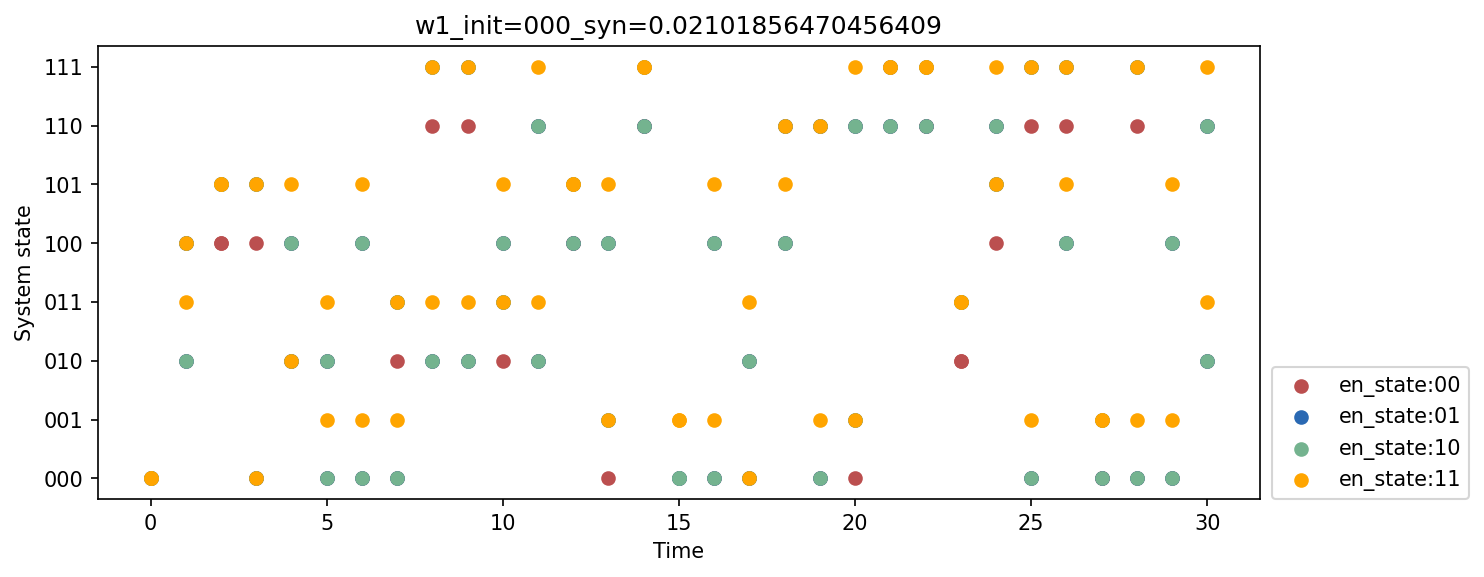

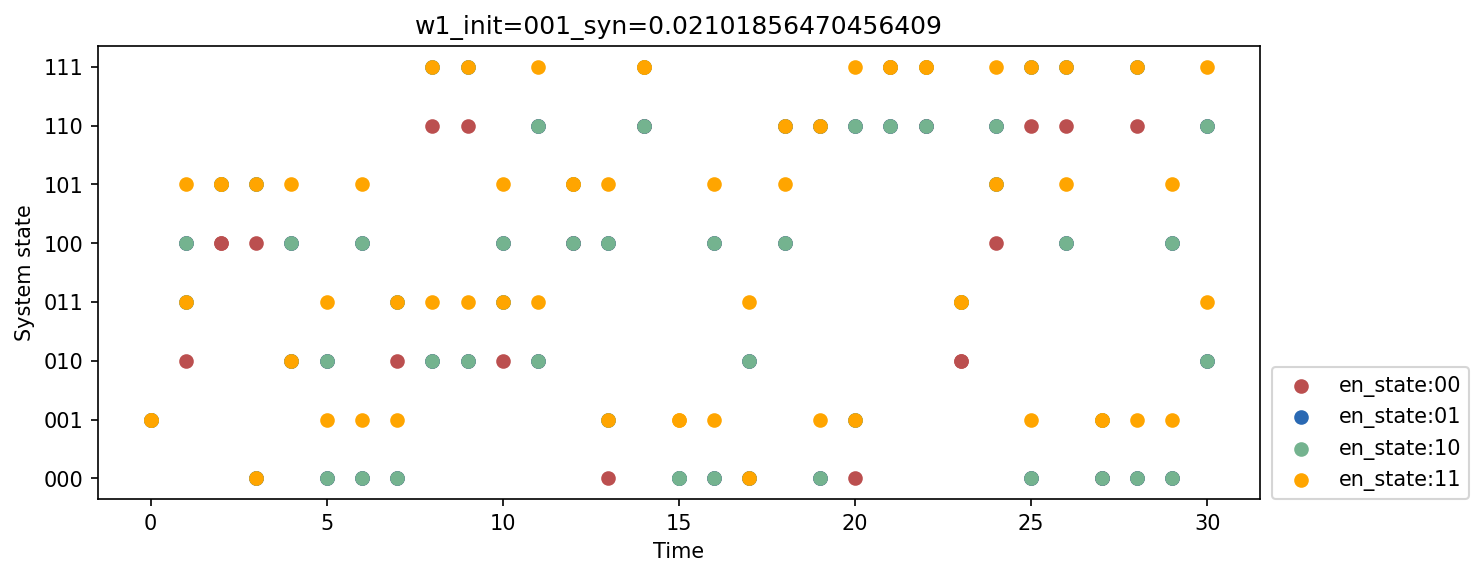

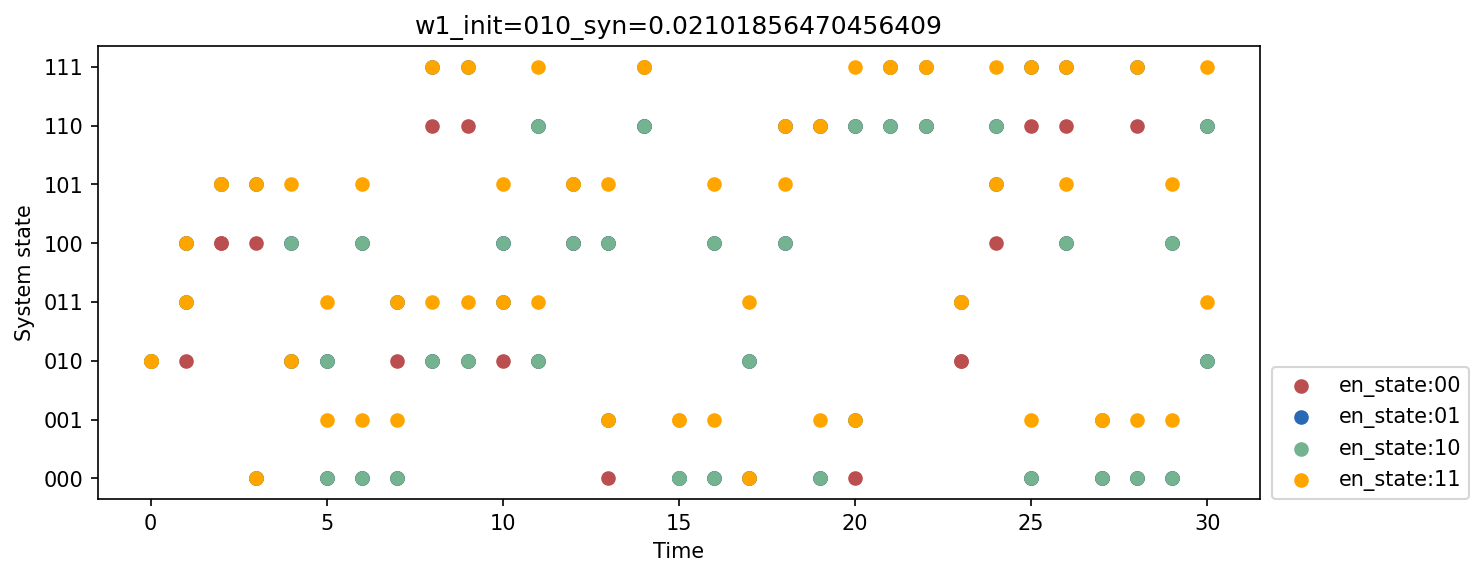

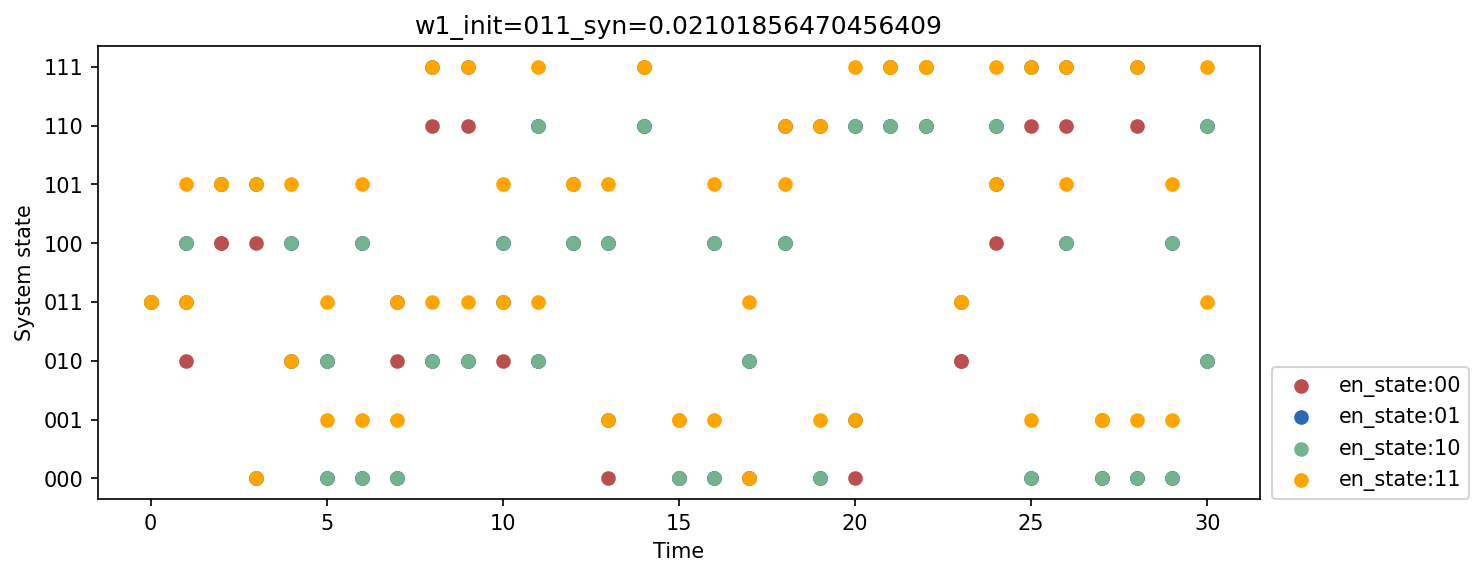

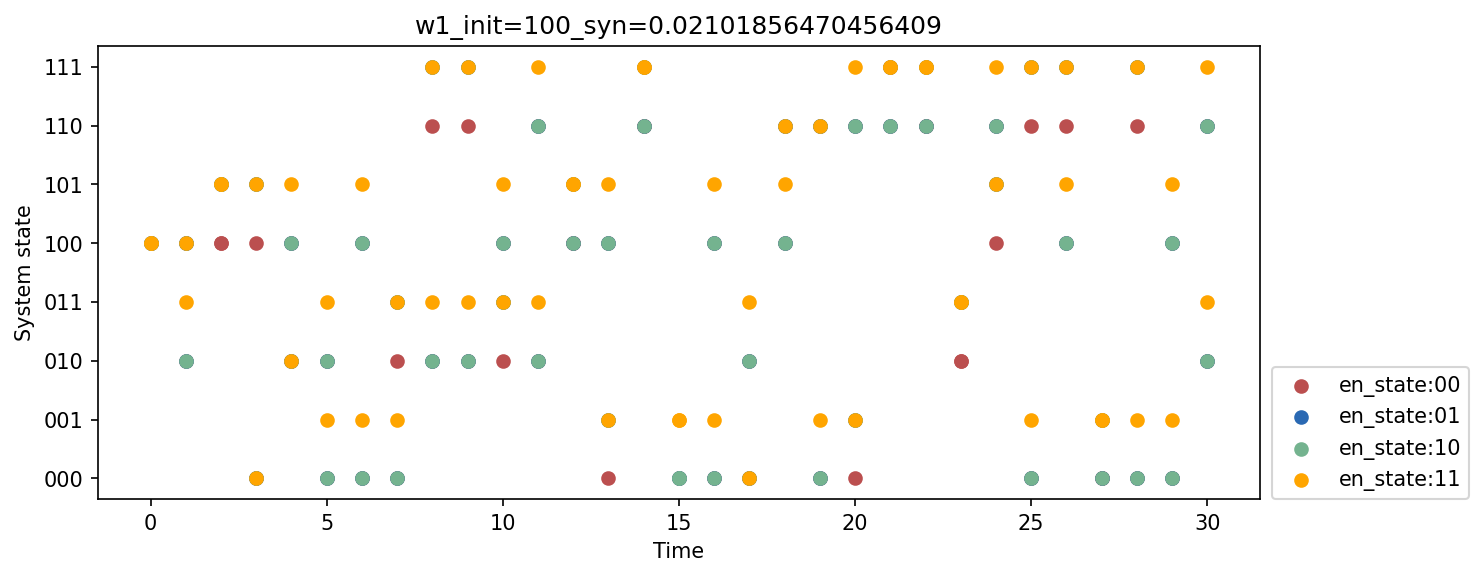

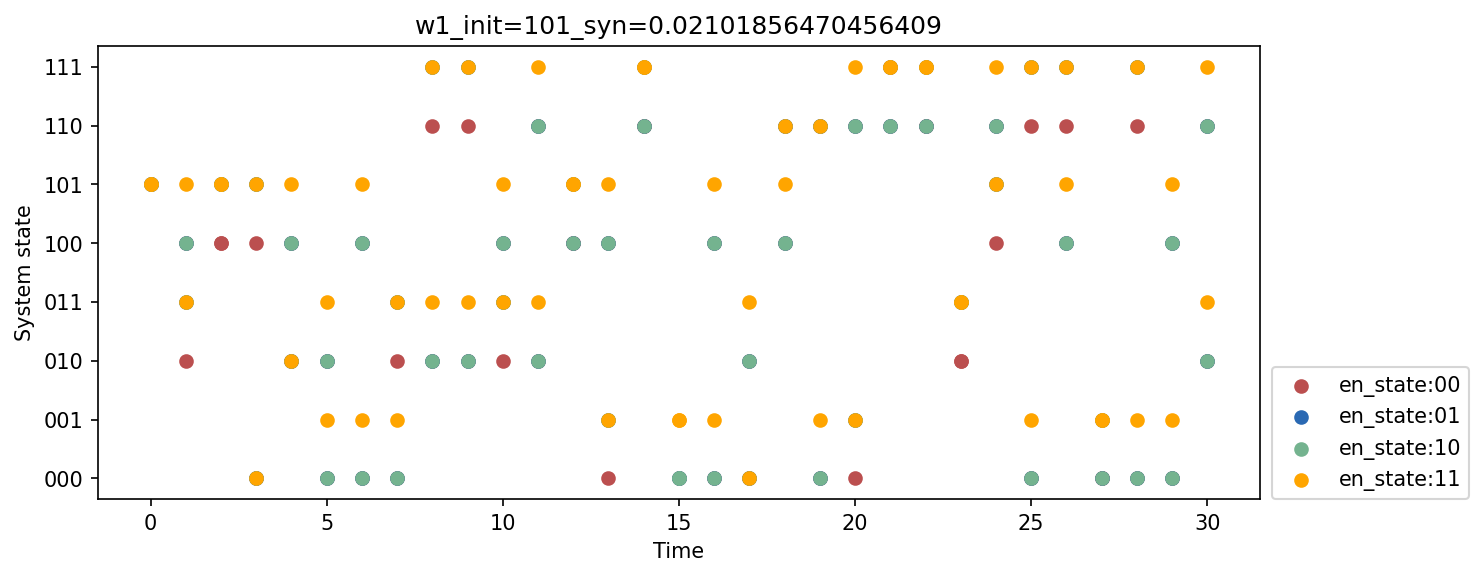

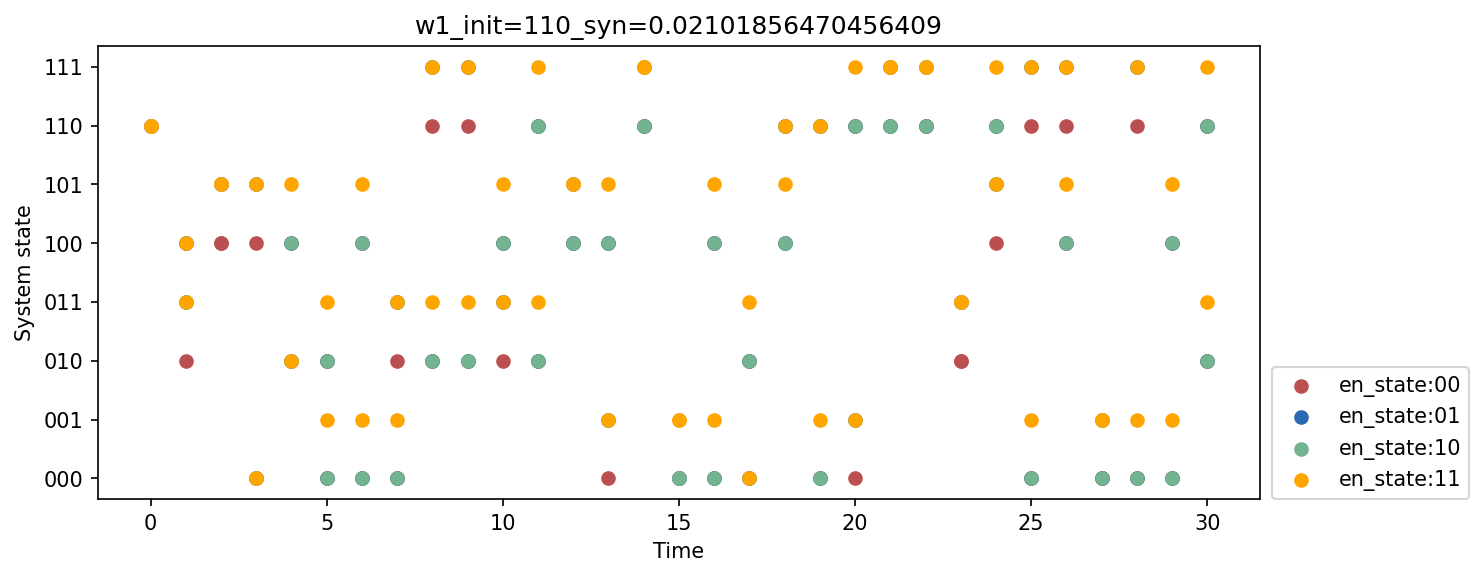

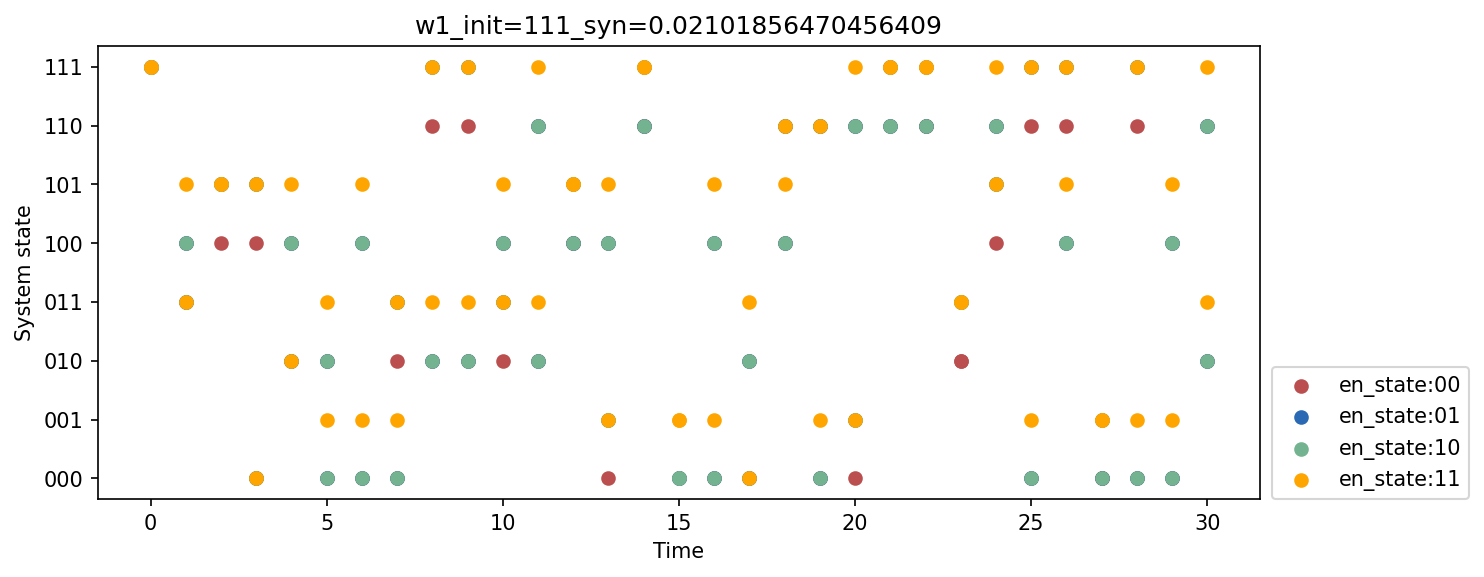

(0.06942894343955978, 0.16811554822785174, 0.02101856470456409)

In [5]:
steps = 30
k=1
serie_plot(bnet, w=w1, k=k, steps=steps, seeds=2, name='w1')


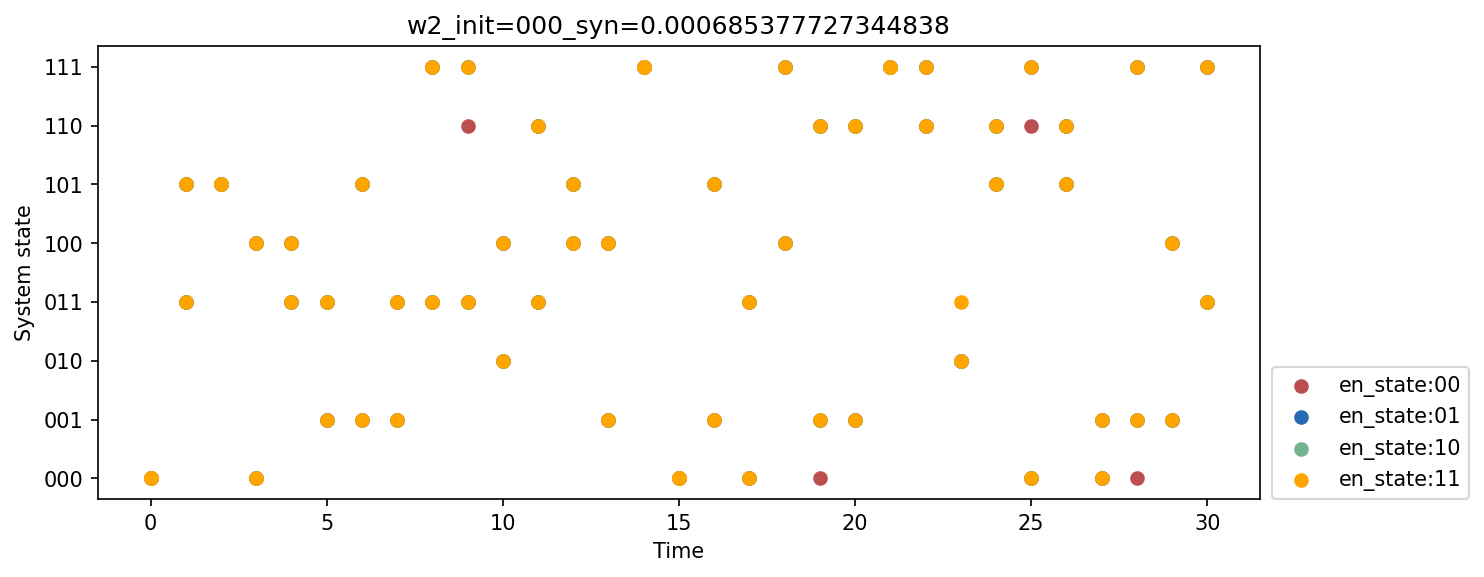

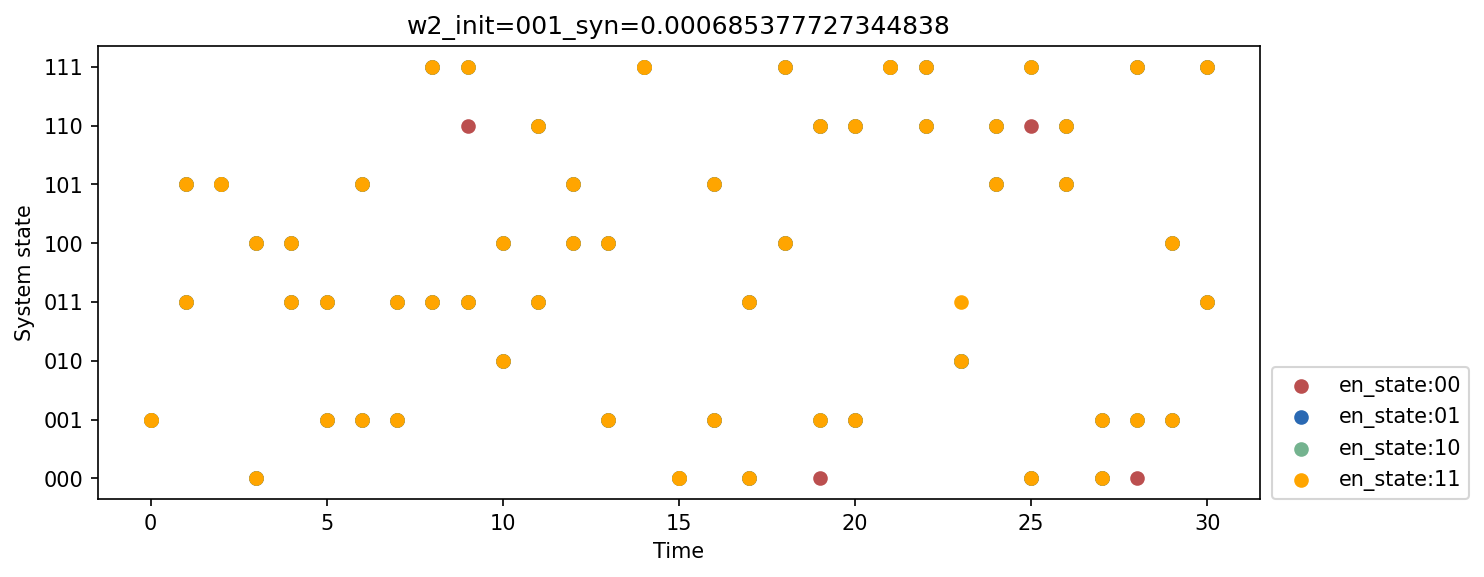

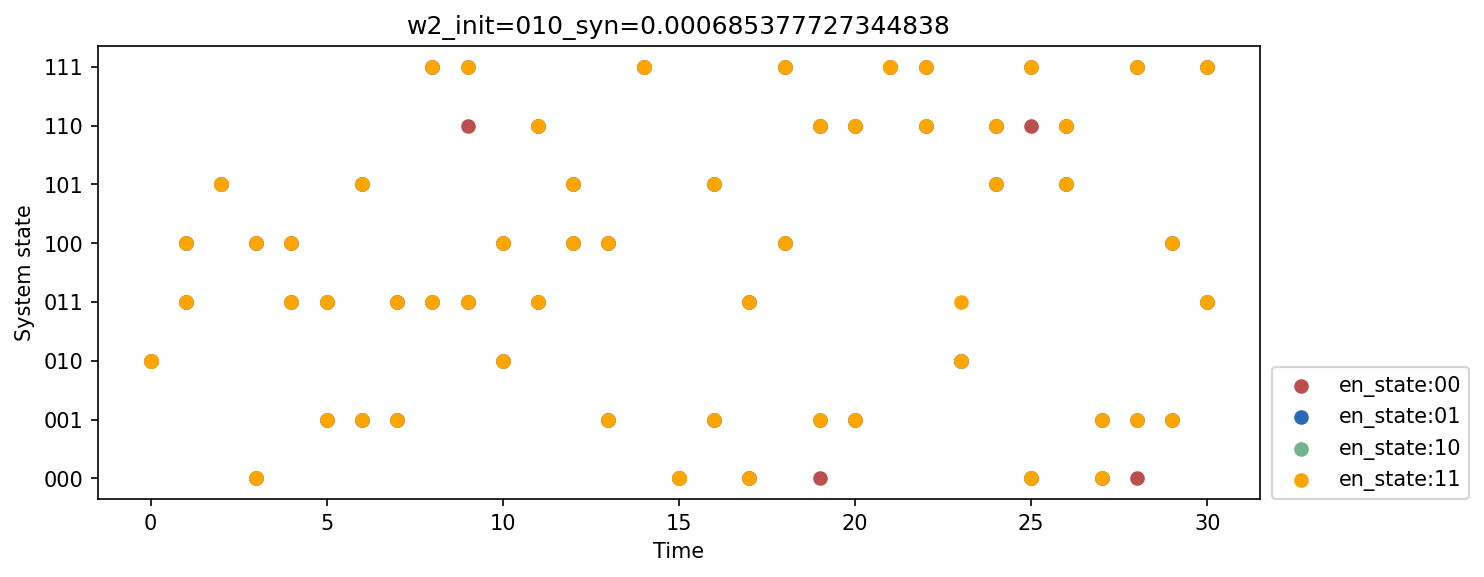

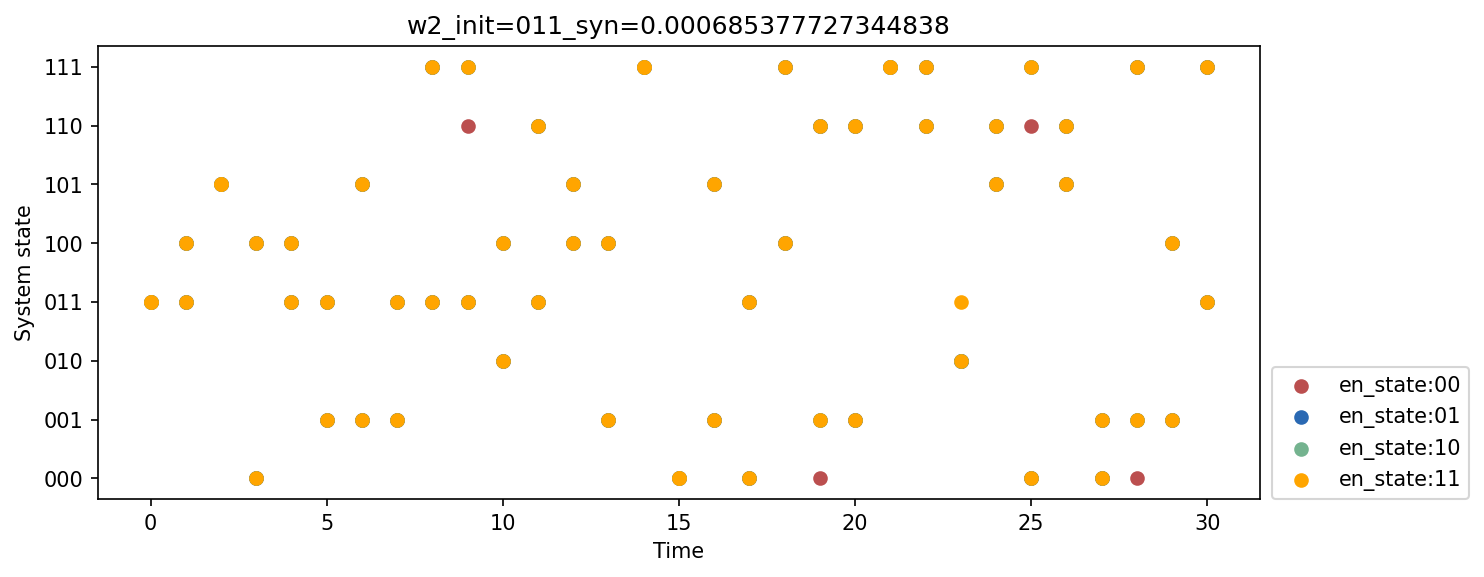

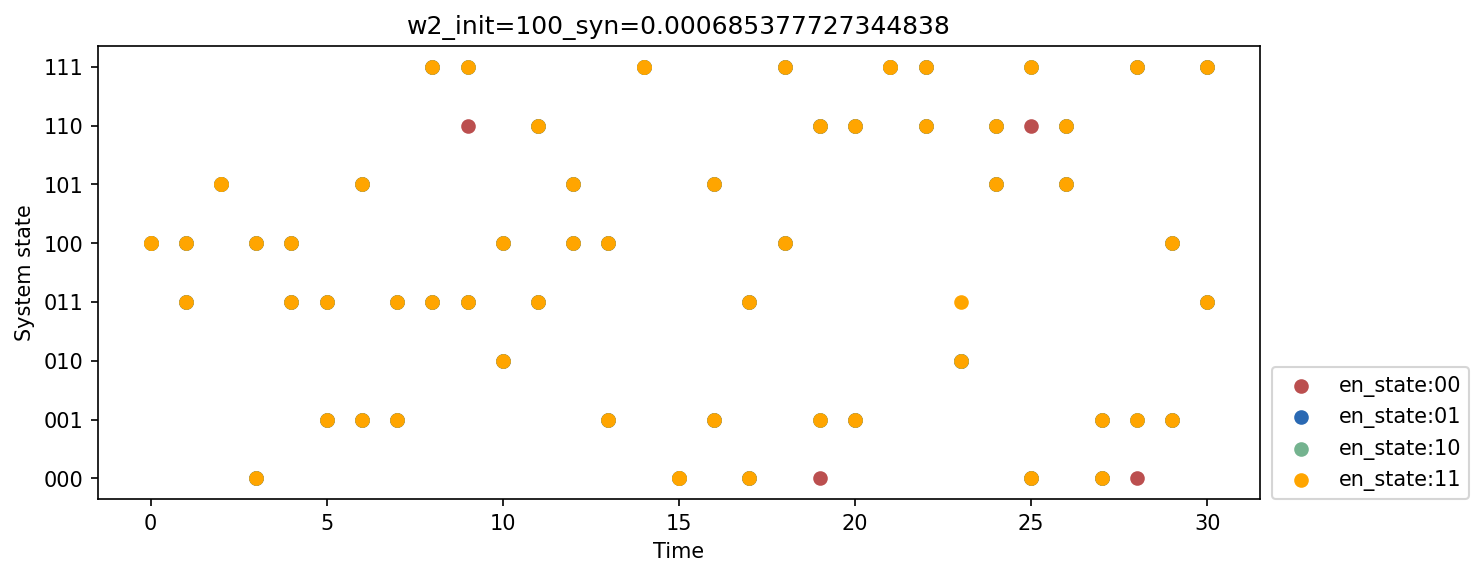

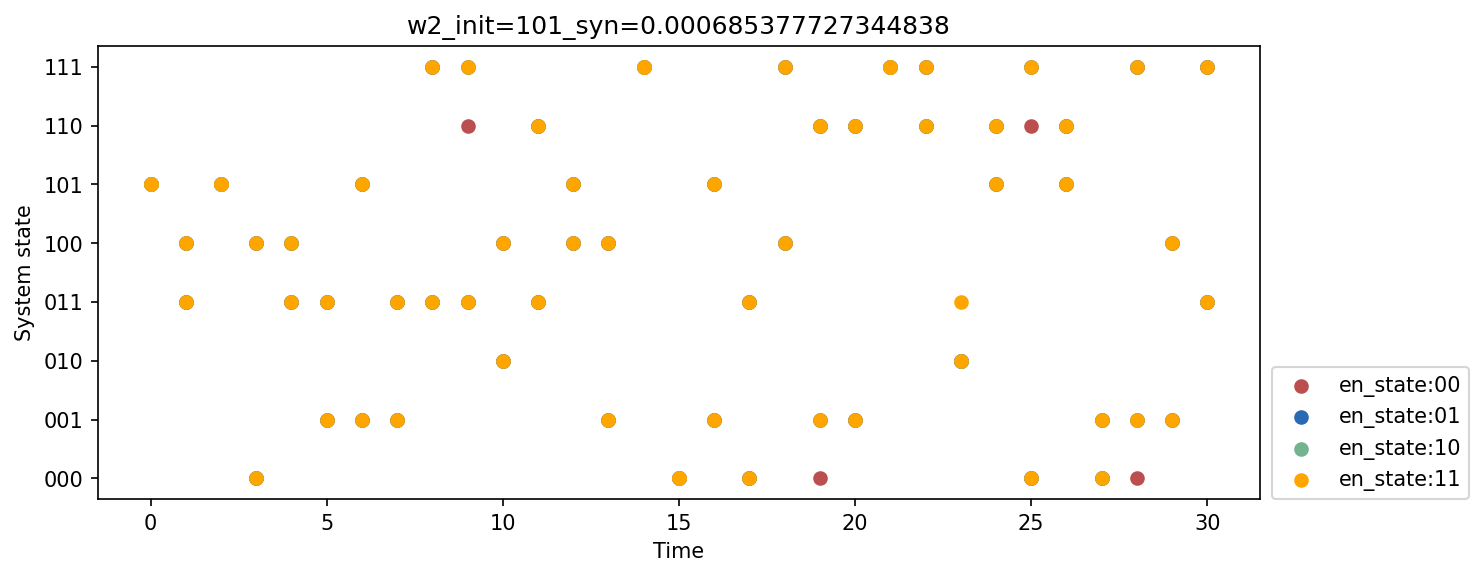

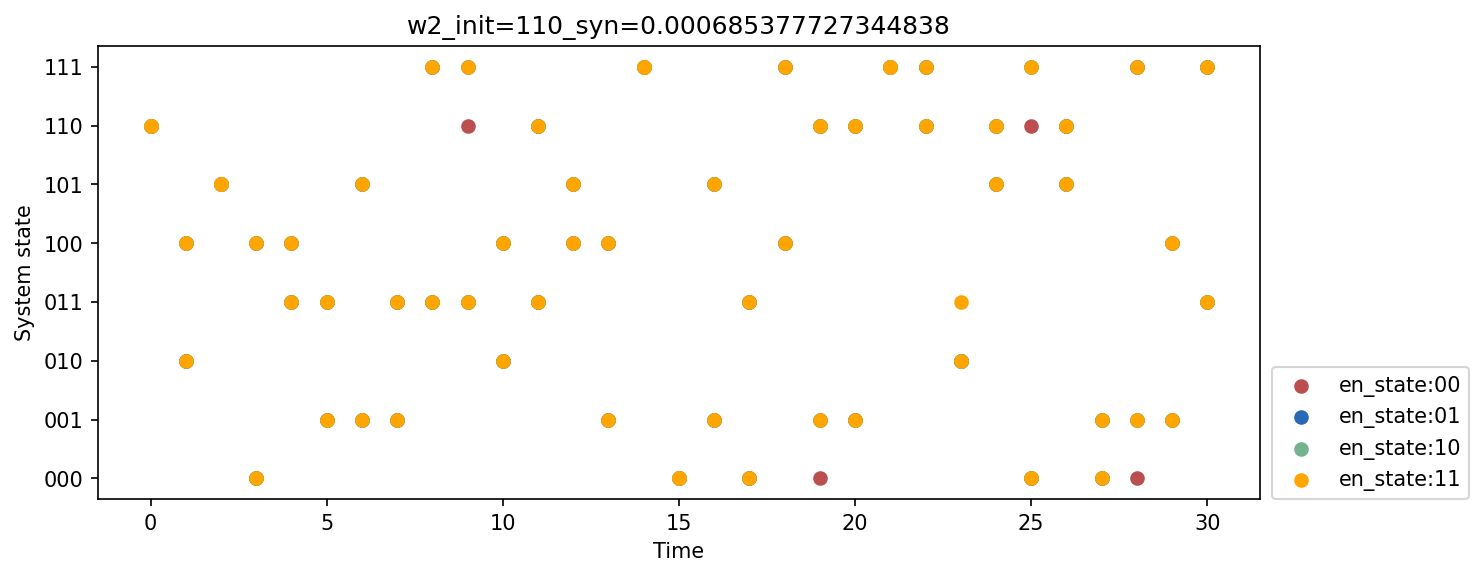

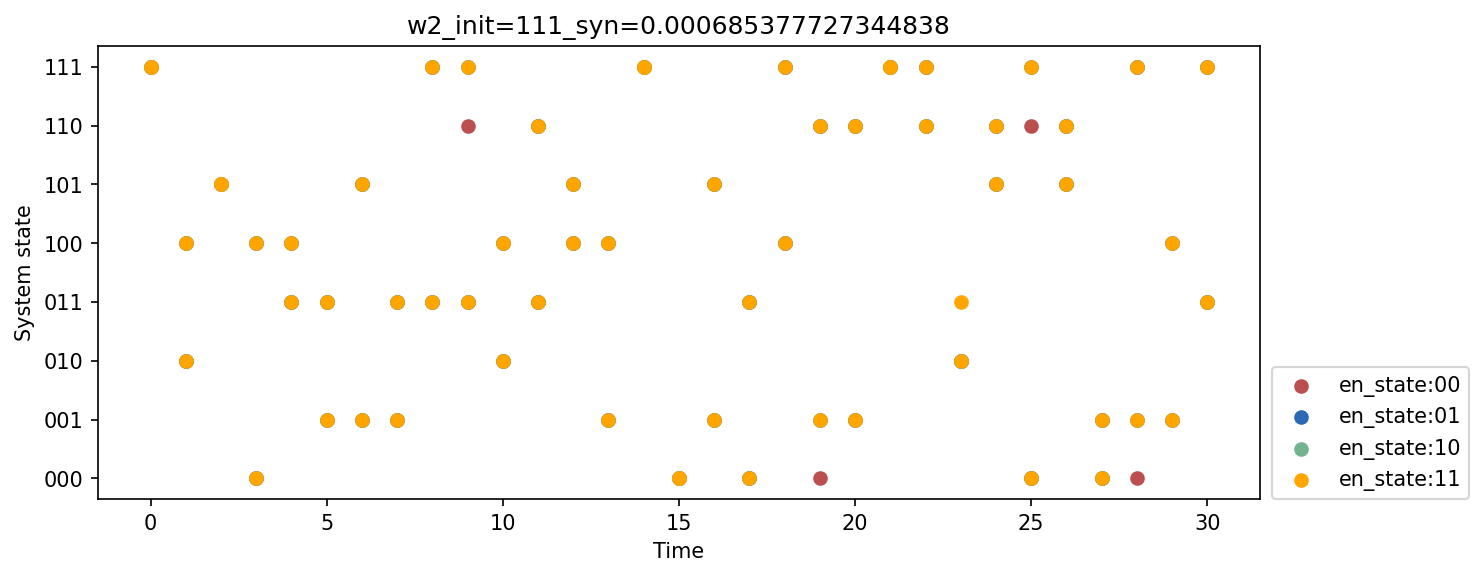

(0.20510884876011298, 0.0019839334579408543, 0.000685377727344838)

In [6]:
steps = 30
k=1
serie_plot(bnet, w=w2, k=k, steps=steps, seeds=2, name='w2')

# 最佳噪音实验复现

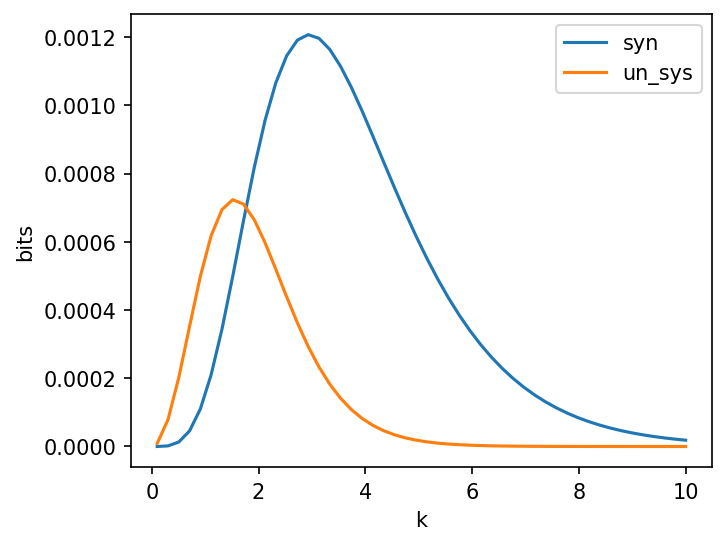

In [10]:
ww = {
    'w_ab': 1,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': 1,
    'w_bc': 1,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w1a': -0.05,
    'w1b': -0.05,
    'w1c': -0.05,
    'w2a': -0.05,
    'w2b': -0.05,
    'w2c': -0.05
}

bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w1a',
    ('E1', 'B'): 'w1b',
    ('E1', 'C'): 'w1c',
    ('E2', 'A'): 'w2a',
    ('E2', 'B'): 'w2b',
    ('E2', 'C'): 'w2c',
}

syn_list = []
un_sys_list = []
un_en_list = []
k_axis = np.linspace(0.1, 10, 50)
for k in k_axis:
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(k_axis, syn_list, label='syn')
plt.plot(k_axis, un_sys_list, label="un_sys")
#plt.plot(k_axis, un_en_list, label="un_en")
plt.xlabel('k')
plt.ylabel('bits')
plt.legend()

# plt.figure(figsize=(5,4),dpi=150)
# plt.plot(k_axis, un_sys_list)
# plt.xlabel('k')
# plt.ylabel('un')
#un_sys, un_en, syn = serie_plot(bnet, w, k, steps, seeds=1)

# 不同系统结构应对环境变化

          abce1e2   Abce1e2   aBce1e2   ABce1e2   abCe1e2   AbCe1e2   aBCe1e2  \
abce1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
Abce1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
aBce1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
ABce1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
abCe1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
AbCe1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
aBCe1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
ABCe1e2  0.097678  0.035934  0.035934  0.013219  0.035934  0.013219  0.013219   
abcE1e2  0.031250  0.031250  0.031250  0.031250  0.031250  0.031250  0.031250   
AbcE1e2  0.031250  0.031250  0.031250  0.031250  0.031250  0.031250  0.031250   
aBcE1e2  0.031250  0.031250  0.031250  0.031250  0.031250  0.031250  0.031250   
ABcE1e2  0.031250  0.031250 

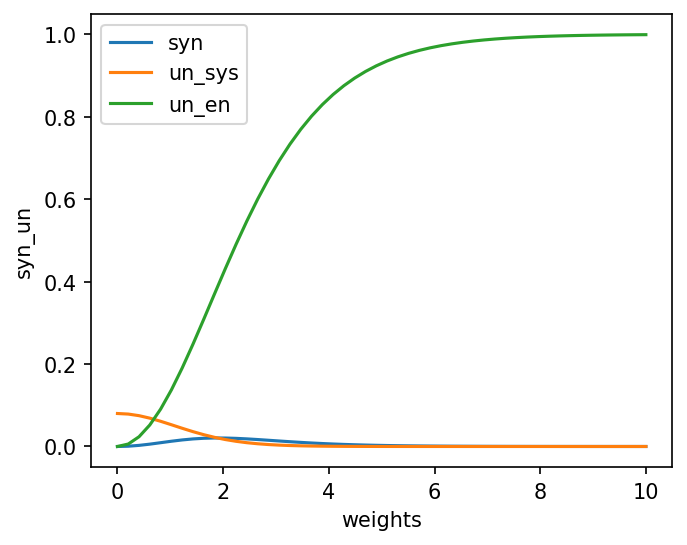

In [11]:
k = 1

ww = {
    'w_ab': 0,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': 0,
    'w_bc': 0,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w11': 0.5,
    'w12': 0.5,
    'w13': 0.5,
    'w21': 0.5,
    'w22': 0.5,
    'w23': 0.5
}

bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w11',
    ('E1', 'B'): 'w12',
    ('E1', 'C'): 'w13',
    ('E2', 'A'): 'w21',
    ('E2', 'B'): 'w22',
    ('E2', 'C'): 'w23',
}

syn_list = []
un_sys_list = []
un_en_list = []
w_axis = np.linspace(0, 10, 50)
for w in w_axis:
    ww['w_ab'] = w
    ww['w_bc'] = w
    ww['w_ca'] = w
    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    if w == 0:
        print(tpm)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.plot(w_axis, un_en_list, label="un_en")
plt.xlabel('weights')
plt.ylabel('syn_un')
plt.legend()
#un_sys, un_en, syn = serie_plot(bnet, w, k, steps, seeds=1)

Text(0, 0.5, 'syn')

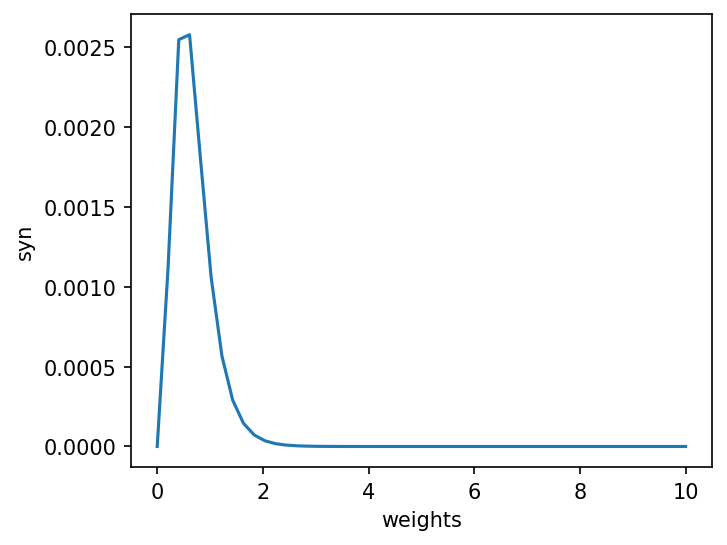

In [32]:
k = 1

ww = {
    'w_ab': 0,
    'w_ba': 0,
    'w_ac': 0,
    'w_ca': 0,
    'w_bc': 0,
    'w_cb': 0,
    'w_a': 0,
    'w_b': 0,
    'w_c': 0,
    'w11': -0.5,
    'w12': -0.5,
    'w13': -0.5,
    'w21': -0.5,
    'w22': -0.5,
    'w23': -0.5
}

bnet = {
    ('A', 'B'): 'w_ab',
    ('B', 'A'): 'w_ba',
    ('A', 'C'): 'w_ac',
    ('C', 'A'): 'w_ca',
    ('B', 'C'): 'w_bc',
    ('C', 'B'): 'w_cb',
    ('A', 'A'): 'w_a',
    ('B', 'B'): 'w_b',
    ('C', 'C'): 'w_c',
    ('E1', 'A'): 'w11',
    ('E1', 'B'): 'w12',
    ('E1', 'C'): 'w13',
    ('E2', 'A'): 'w21',
    ('E2', 'B'): 'w22',
    ('E2', 'C'): 'w23',
}

syn_list = []
w_axis = np.linspace(0, 10, 50)
for w in w_axis:
    ww['w_ab'] = w
    ww['w_bc'] = w
    ww['w_ca'] = w

    tpm, tpm_v = make_tpm(bnet, ww, k=k)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list)
plt.xlabel('weights')
plt.ylabel('syn')
#un_sys, un_en, syn = serie_plot(bnet, w, k, steps, seeds=1)

# 同时调节k和w

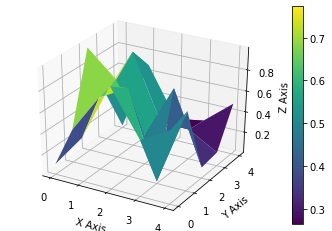

In [33]:


# 创建一个新的figure
fig = plt.figure()

# 添加一个3D坐标轴
ax = fig.add_subplot(111, projection='3d')

# 创建一个二维数组，例如一个5x5的随机数组
data = np.random.rand(5, 5)

# 为了在3D图中展示这个二维数组，我们需要创建X, Y坐标网格
x = np.arange(data.shape[0])
y = np.arange(data.shape[1])
X, Y = np.meshgrid(x, y)

# 将二维数组的值作为Z坐标
Z = data

# 绘制3D曲面图
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# 添加颜色条
fig.colorbar(surf)

# 设置坐标轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# 显示图形
plt.show()

# 梯径分析序列

In [3]:
import string

# 获取所有小写字母
lowercase_letters = list(string.ascii_lowercase)

# 获取所有大写字母
uppercase_letters = list(string.ascii_uppercase)

# 合并两个列表
all_letters = lowercase_letters + uppercase_letters



In [7]:
lens = 2000
init_state = '00111'
tpm1, tpm_v1 = make_tpm(bnet, w1, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v1, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w1_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))


In [8]:

tpm2, tpm_v2 = make_tpm(bnet, w2, k=1)
for seed in range(3):
    serie, _ = tpm_series(tpm_v2, init_state, lens, seed)
    letter_list = [all_letters[i] for i in serie]
    with open('w2_'+init_state+'_'+str(seed)+'.txt', 'w') as f:
            f.write(''.join(letter_list))